## Introduction

This Jupyter Notebook allows you to analyse the data of the fluorescence rise of a photosynthetic organism (PA).   
The input data correspond to the fluorescence response of the PA to a jump of light as described in Section XXX of XXX (TODO when published).  
The duration is expected to be between 300ms and 1s.
The acquisition rate is not limiting for the analysis as long as it can capture a phenomena with a 100µs dynamics.   
We usually acquire the data at 3MHz.  

User: 
- adapt the pre-processing to your data:
    - time array 
    - area of interest: during the jump of light
    - moving average to smooth the signal
    - logarithmic sub-sampling to accelerate the fit  
    
    
- select your source's wavelength

**From the fit of the initial phase of the fluorescence rise, you can obtain an estimate the light intensity received by the sample with a factor 2 precision.**

In [1]:
from scipy import optimize
import glob
import copy
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from mvgavg import mvgavg
%matplotlib widget

## Pre-processing the data (make changes here)

In [10]:
def pre_process(file, N_mvg = 10, N_log = 10000, columns = [1,2]):
    
    #read data
    data_sequence = pd.read_csv(file)
    head = list(data_sequence.keys())
    time_array = np.array(data_sequence[head[columns[0]]])
    fluo = np.array(data_sequence[head[columns[1]]])
    #remove blank
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    #normalise
    fluo_ref = fluo/fluo.max()    
    #collect the fluorescence rise: during the jump of light
    ind_ref = (fluo_ref>0.1)
    
    #perform moving average
    binit = True
    t = mvgavg(time_array[ind_ref], N_mvg, binning = binit)
    y = mvgavg(fluo[ind_ref], N_mvg, binning = binit)
    
    # start at 0
    t-=t[0]
    
    #logarithmic subsampling to accelerate the fit
    ind= np.unique(np.logspace(np.log10(1), np.log10(len(t)-1), N_log).astype(int))
    t = t[ind]
    y = y[ind]

    return t, y


Text(0, 0.5, 'fluorescence rise')

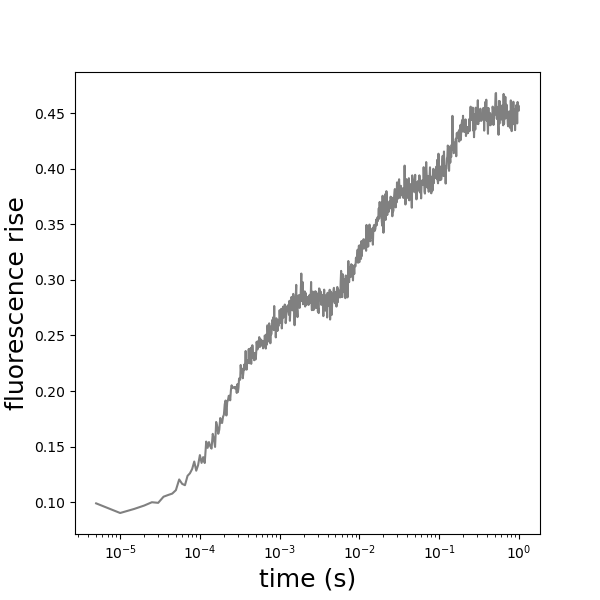

In [15]:
file_path = glob.glob("../data/*363_blue.csv")[0]

get_ints = [int(s) for s in file_path.split("_") if s.isdigit()]
voltage = get_ints[-1]
t, y = pre_process(file_path, N_mvg=10, N_log = 1000, columns = [1,2]) #play with N_mvg and N_log

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.semilogx(t,y, "grey", label = "preprocessed data")
ax.set_xlabel("time (s)", fontsize=18)
ax.set_ylabel("fluorescence rise", fontsize=18)

In [13]:
plt.plot(t,y)

## Fiting functions

In [16]:
def sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    y = F0 + Aoj*(1-np.exp(-koj*tdata))**soj + Aji*(1-np.exp(-kji*tdata))**sji +  Aip*(1-np.exp(-kip*tdata))**sip
    
    return y
     

def residuals(parameters,x_data,y_observed,func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed

def multiexp_fit(t, y):
    """ triexponential sigmoidal fit of the fluorescence rise based on Joly & Carpentier 2009"""

    #initial parameters based on Joly & Carpentier, 2009
    dF = y.max()-y.min()
    x0 = [y.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (t, y, sigmoidal_OJIP))
    
    #recover the characteristic time of the first phase (O-J)
    tau = 1/parameters_estimated.x[2]
    
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    
    return tau, ypred
    
    
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.24 + y0


def get_fit(t, y):    

    time_spread = t.max()-t.min()
    start = np.mean(y[0])
    stop = np.mean(y[-10:])
    x0 = [start, 1/time_spread, stop]
    t = t-t[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (t, y, exp_decay))

    tau = parameters_estimated.x[1]
    pos_tau = find_nearest(t, tau)
    x0 = parameters_estimated.x #initial guess: parameters from previous fit
    #second fit
    parameters_estimated  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (t[0:int(pos_tau*5)], y[0: int(pos_tau*5)], exp_decay))

    return  parameters_estimated.x

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Extraction of tau

C:\Users\Alienor\AppData\Local\Temp\ipykernel_13324\1946166377.py:51: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0


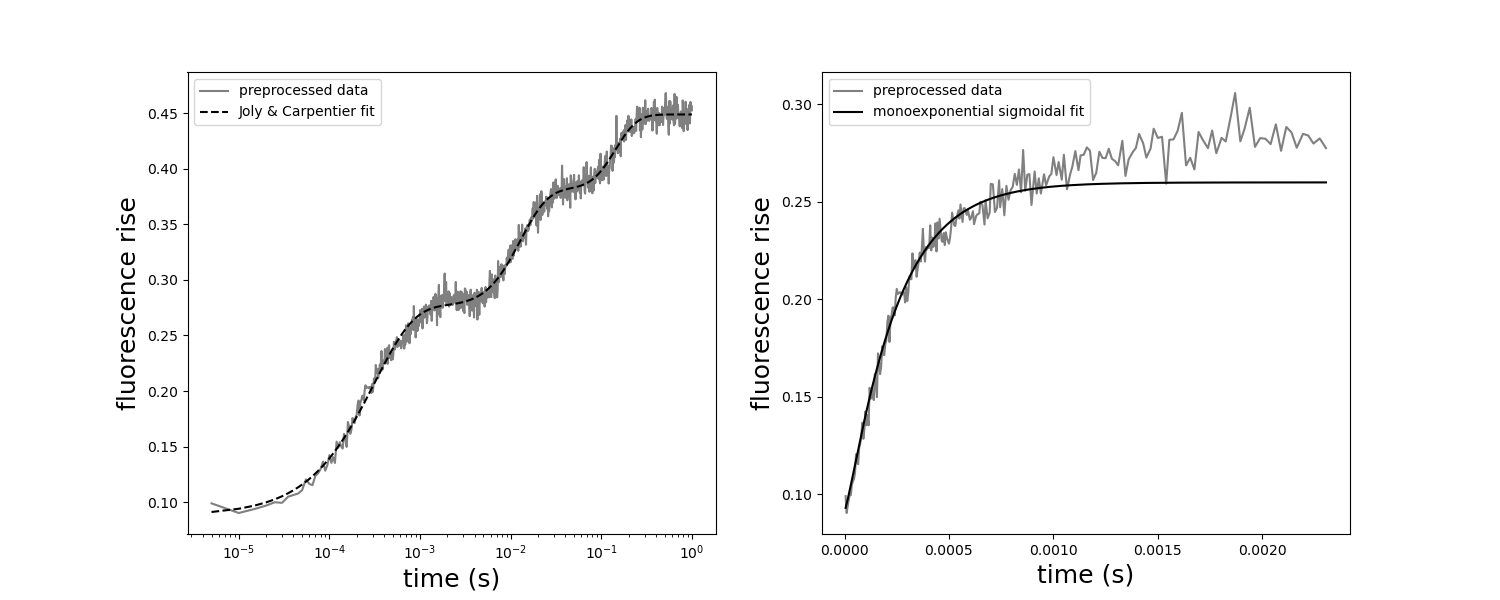

In [17]:
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].semilogx(t,y, "grey", label = "preprocessed data")
axs[0].set_xlabel("time (s)", fontsize=18)
axs[0].set_ylabel("fluorescence rise", fontsize=18)

#PRELIMINARY MULTIEXPONENTIAL FIT
tau, ypred =  multiexp_fit(t,y)

axs[0].plot(t, ypred, "--k", label = "Joly & Carpentier fit")

axs[0].legend()
#MONOEXPONENTIAL FIT ON RESTRICTED SEGMENT (identified as OJ phase)
pos = 3*tau
pos_tau = find_nearest(t, pos)
params = get_fit(t[:pos_tau], y[:pos_tau])

#PLOTTING
D = 1.5
t_mono = t[:int(pos_tau*D)]
ypred_mono = exp_decay(params, t_mono)
tau_mono = params[1]

axs[1].plot(t_mono, y[0:int(pos_tau*D)], "gray", label = "preprocessed data")
axs[1].plot(t_mono, ypred_mono, "k", label = "monoexponential sigmoidal fit")
axs[1].set_xlabel("time (s)", fontsize=18)
axs[1].set_ylabel("fluorescence rise", fontsize=18)
axs[1].legend()

plt.savefig("../images/OJIP_fit.png")

## Sigma value for given light source

In [18]:
# SELECT WAVELENGTH OF THE LIGHT SOURCE
wl = 470

# USE THE AVERAGE SPECTRUM OF SIGMA
df = pd.read_csv("../data/average_sigma_spectra.csv")
excitation_source = df.loc[df["wavelength (nm)"] == wl]
excitation_source


,Unnamed: 0,wavelength (nm),excitation spectra (10e6.m²/mol)
70,70,470.0,1.442267


In [19]:
#COLLECT THE VALUE OF SIGMA

sigma_source = excitation_source.values[0][-1]
print("sigma = ", sigma_source)

sigma =  1.4422666694174286


## Intensity prediction

In [20]:
# PREDICT THE LIGHT INTENSITY (FACTOR 2 ERROR)

light_intensity  = 1/(tau_mono*sigma_source)
print(1/tau_mono)
print("The light intensity received by the sample is between ", light_intensity/2, "and ", light_intensity*2, "µEins/m²/s")

4594.095674900113
The light intensity received by the sample is between  1592.6651334027554 and  6370.6605336110215 µEins/m²/s
